# Prediction
After the exploratory data analysis, a prediction will be made.
The folowing steps for this prediction:
1. Preprocessing - Handle missing data, Feature engineering.
2. Predictions - predicting with validation data and then with test data, metrics.
## 📚

In [114]:
#numpy
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer

#pipeline tools
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from pipelinehelper import PipelineHelper
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#warning hadle
import warnings
warnings.filterwarnings("always")
warnings.filterwarnings("ignore")

#plotly
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

## Baseline 1: Basic approach

### Decisions:
* **Preprocessing:**
    1. **Missing data:** **Categoric** - fill with most frequent. **Discrete** - fill with most frequent. **Continuous** - fill with median.               
    2. **Feature Engineering**: only categoric labels, one hot encoding.
* **Model training** - using cross validation in validation data on a simple decision tree model.
* **Model testing** - train on whole train + validation set and use test data for results.

**Preprocessing**

In [115]:
# Preprocessing for continuous data
contiuous_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='most_frequent')),
('oh', OneHotEncoder())
])

# Preprocessing for discrete data
disc_transformer =  SimpleImputer(strategy='median')    

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', contiuous_transformer, Continuous+["LOAN"]),
        ('cat', categorical_transformer, Cats),
        ('disc', disc_transformer, Discrete)
    ])

**Model**

In [116]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state = 42)

**Validation Prediction**

In [117]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
# Bundle preprocessing and modeling code in a pipeline
Baseline1 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
Baseline1.fit(X_train2, y_train2)

# Preprocessing of validation data, get predictions
b1_val_preds = Baseline1.predict(X_val)

# Evaluate the model
b1_val_score = accuracy_score(y_val, b1_val_preds)
b1_val_auc = roc_auc_score(y_val, b1_val_preds)
b1_val_f1 = f1_score(y_val, b1_val_preds)

print('accuracy score:', b1_val_score)
print("roc auc score: ",b1_val_auc)
print("f1 score: ",b1_val_f1)

accuracy score: 0.8582214765100671
roc auc score:  0.7699598410287355
f1 score:  0.6515463917525772


In [118]:
from sklearn.model_selection import cross_val_score
CV = cross_val_score(Baseline1, X_train, y_train, cv=5)
print(f"validation accuracy on 5 fold cross validation: {CV}")
print(f"validation mean accuracy: {CV.mean()}")

validation accuracy on 5 fold cross validation: [0.88155136 0.87002096 0.86792453 0.86883526 0.85729276]
validation mean accuracy: 0.869124974427


**Test Preduction**

In [119]:
Baseline1.fit(X_train, y_train)
b1_test_preds = Baseline1.predict(X_test)
b1_test_score = accuracy_score(y_test, b1_test_preds)
b1_test_auc = roc_auc_score(y_test, b1_test_preds)
b1_test_f1 = f1_score(y_test, b1_test_preds)
print('test accuracy score:', b1_test_score)
print("test roc auc score: ",b1_test_auc)
print("f1 score: ",b1_test_f1)

test accuracy score: 0.8548657718120806
test roc auc score:  0.7840731920783212
f1 score:  0.6679462571976968


**Area Under Curve plot**
 
 Information in Roc Curve is available [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

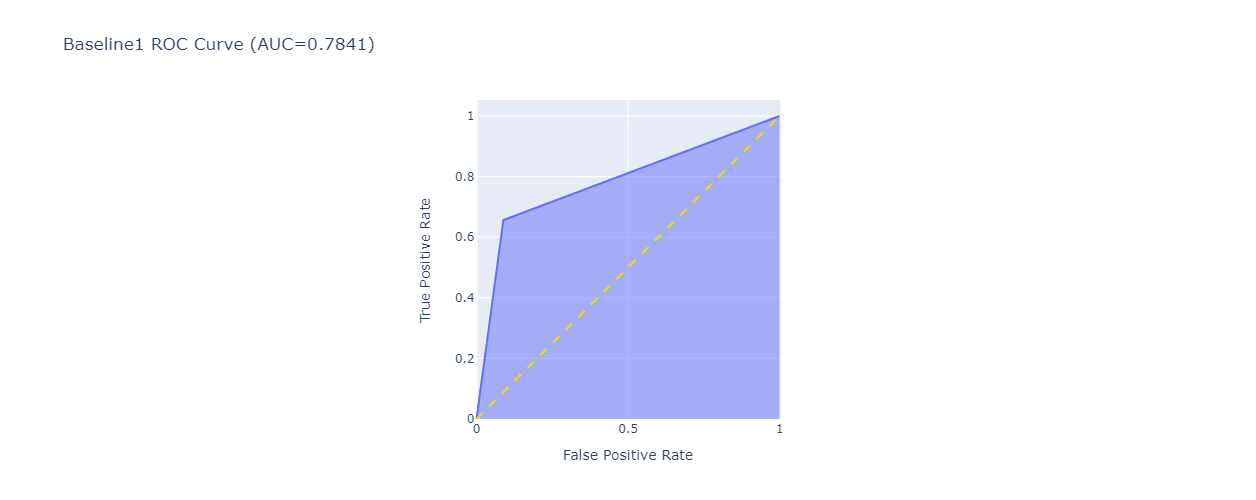

In [120]:
import plotly.express as px
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, b1_test_preds)
fig = px.area(
    x=fpr, y=tpr,
    title=f'Baseline1 ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(color="gold",dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [121]:
from sklearn.metrics import classification_report
print(pd.crosstab(y_test, b1_test_preds, rownames=["Actual"], colnames=["Predicted"]))
print(f"\n{classification_report(y_test, b1_test_preds)}")

Predicted    0    1
Actual             
0          845   82
1           91  174

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       927
           1       0.68      0.66      0.67       265

    accuracy                           0.85      1192
   macro avg       0.79      0.78      0.79      1192
weighted avg       0.85      0.85      0.85      1192



### Baseline 1 Summary
The model was cross validated 5 times and tested 1 time, `random_state=42` was inserted to fix results (both splits and model):
* **Raw accuracy**: validation set had an impressive score of 85.82%, test set had 85.49% which is slightly lower but expected (no overfitting). cross validation reached 86.9%.
* **Auc**: validation set had a score of 0.769, test set had 0.7841 which is higher.
* **F1 score**: validation set had a score of 0.6515, test set had 0.668 which is higher.

The baseline is saved for comparison as a pandas dataframe: 

In [122]:
Baseline1 = pd.DataFrame({"val_acc": b1_val_score,"val_auc": b1_val_auc,"val_f1": b1_val_f1,
                          "test_acc": b1_test_score,"test_auc": b1_test_auc,"test_f1": b1_test_f1}, index=["Baseline1"])
Baseline1

,val_acc,val_auc,val_f1,test_acc,test_auc,test_f1
Baseline1,0.858221,0.76996,0.651546,0.854866,0.784073,0.667946


## Baseline 2: Scaling parameters and tuning hyper parameters

### Decisions:
* **Preprocessing:**
    1. **Missing data:** **Categoric** - fill with most frequent. **Discrete** - fill with most frequent. **Continuous** - fill with median.               
    2. **Feature Engineering**: categoric labels - one hot encoding, continuous parameters: standart scaling (z-score).
* **Model training** - using grid search in validation data on a decision tree model for maximizing "f1".
* **Model testing** - train on whole train + validation set and use test data for results.

**Preprocessing**

In [123]:
from sklearn.preprocessing import StandardScaler

# Preprocessing for continuous data
contiuous_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='median')),
('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='most_frequent')),
('oh', OneHotEncoder())
])

# Preprocessing for discrete data
disc_transformer = SimpleImputer(strategy='median')  

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', contiuous_transformer, Continuous+["LOAN"]),
        ('cat', categorical_transformer, Cats),
        ('disc', disc_transformer, Discrete)
    ])

**Model**

In [124]:
Baseline2 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])
Baseline2

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MORTDUE', 'VALUE', 'CLAGE',
                                                   'DEBTINC', 'LOAN']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oh',
                                                                   OneHotEncoder())]),
         

**Grid Search CV**

The validation will be searched with 3 hyperparameters: `min_samples_leaf`, `max_features`, `max_depth` and `random_state = 42` for fixing results.

In [125]:
from sklearn.model_selection import GridSearchCV
hyperparameters = {"model__random_state":[42],"model__min_samples_leaf":[None,2,3,4],"model__max_features":[None,1,3,5],"model__max_depth":[None,1,3,5]}
b2_test_clf = GridSearchCV(Baseline2, hyperparameters,cv = 5, scoring = "f1", n_jobs = -1, verbose = 2)                   

**fit pipeline** 

The fit is executer with the following command: 
```python
%%time
``` 
This measures wall time (the time from the moment the system recived the command until it finished excecution)

In [126]:
%%time
# Fit and tune model
b2_test_clf.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Wall time: 3.36 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MORTDUE',
                                                                          'VALUE',
                                                                          'CLAGE',
                                                                          'DEBTINC',
                                                                        

**The Chosen Parameters**

In [127]:
b2_test_clf.best_params_

{'model__max_depth': 5,
 'model__max_features': None,
 'model__min_samples_leaf': 2,
 'model__random_state': 42}

**Validation Prediction**

In [128]:
b2_val_clf = b2_test_clf.best_estimator_
b2_val_clf.fit(X_train2, y_train2)
b2_val_preds = b2_val_clf.predict(X_val)

# Evaluate the model
b2_val_score = accuracy_score(y_val, b2_val_preds)
b2_val_auc = roc_auc_score(y_val, b2_val_preds)
b2_val_f1 = f1_score(y_val, b2_val_preds)

print('accuracy score:', b2_val_score)
print("roc auc score: ",b2_val_auc)
print("f1 score: ",b2_val_f1)

accuracy score: 0.8666107382550335
roc auc score:  0.7880043280134834
f1 score:  0.6774847870182557


**Test Prediction**

In [129]:
b2_test_preds = b2_test_clf.predict(X_test)

# Evaluate the model
b2_test_score = accuracy_score(y_test, b2_test_preds)
b2_test_auc = roc_auc_score(y_test, b2_test_preds)
b2_test_f1 = f1_score(y_test, b2_test_preds)

print('accuracy score:', b2_test_score)
print("roc auc score: ",b2_test_auc)
print("f1 score: ",b2_test_f1)

accuracy score: 0.8758389261744967
roc auc score:  0.8110317314933545
f1 score:  0.7131782945736432


**Area Under Curve plot**

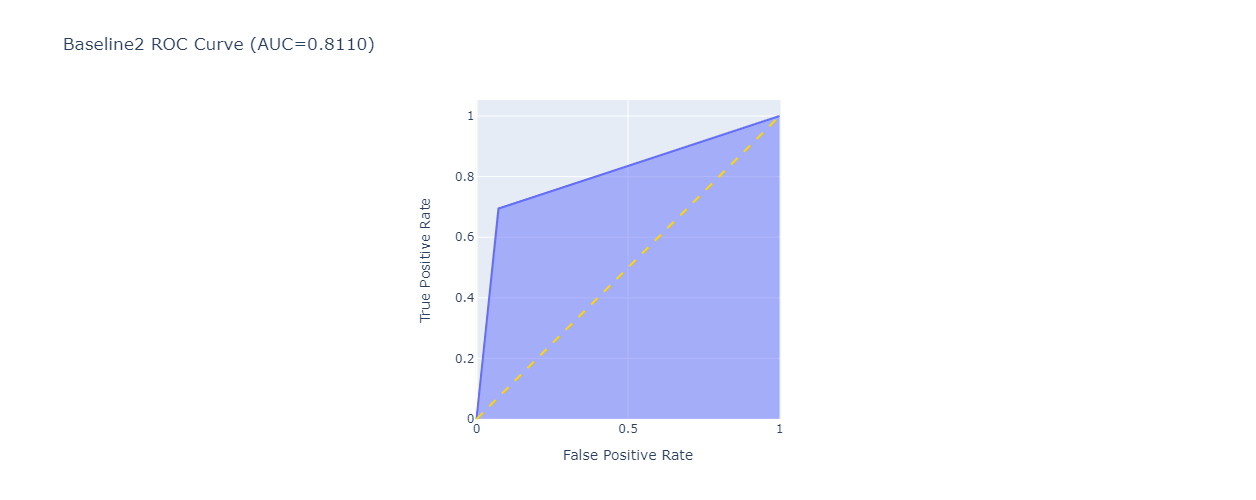

In [130]:
fpr, tpr, thresholds = roc_curve(y_test, b2_test_preds)
fig = px.area(
    x=fpr, y=tpr,
    title=f'Baseline2 ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(color="gold",dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [131]:
print(pd.crosstab(y_test, b2_test_preds, rownames=["Actual"], colnames=["Predicted"]))
print(f"\n{classification_report(y_test, b2_test_preds)}")

Predicted    0    1
Actual             
0          860   67
1           81  184

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       927
           1       0.73      0.69      0.71       265

    accuracy                           0.88      1192
   macro avg       0.82      0.81      0.82      1192
weighted avg       0.87      0.88      0.87      1192



### Baseline 2 Summary
The Pipeline was cross validated 5 times then predicted with original validation set and then predicted test set 1 time, `random_state=42` was inserted to fix results (both splits and model):
* **Raw accuracy**: validation set had a score of 86.68%, test set had 87.58% which is an impressive improvement from the first baseline.
* **Auc**: validation set had a score of 0.788, test set had 0.811 which is significantly higher.
* **F1 score**: validation set had a score of 0.6775, test set had 0.7132 which is significantly higher.

The baseline is saved for comparison as a pandas dataframe

In [132]:
Baseline2 = pd.DataFrame({"val_acc": b2_val_score,"val_auc": b2_val_auc,"val_f1": b2_val_f1,
                          "test_acc": b2_test_score,"test_auc": b2_test_auc,"test_f1": b2_test_f1}, index=["Baseline2"])
Baseline2

,val_acc,val_auc,val_f1,test_acc,test_auc,test_f1
Baseline2,0.866611,0.788004,0.677485,0.875839,0.811032,0.713178


The baslines dataframe is created for comparisons: 

In [133]:
Baselines = pd.concat([Baseline1,Baseline2])
Baselines

,val_acc,val_auc,val_f1,test_acc,test_auc,test_f1
Baseline1,0.858221,0.769960,0.651546,0.854866,0.784073,0.667946
Baseline2,0.866611,0.788004,0.677485,0.875839,0.811032,0.713178


## Baseline 3: tuning preprocessing parameters, Decision between A few models. 

### Decisions:
* **Preprocessing:**
    1. **Missing data:** hyperparamer tune.               
    2. **Feature Engineering**: categoric labels - one hot encoding, continuous parameters: standart scaling (z-score).
* **Model training** - using grid search in validation data on a 5 models for maximizing "f1".
* **Model testing** - train on whole train + validation set and use test data for results.

**Preprocessing**

In [134]:
# Preprocessing for continuous data
contiuous_transformer = Pipeline(steps=[
('imputer', SimpleImputer()),
('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='most_frequent')),
('oh', OneHotEncoder())
])

# Preprocessing for discrete data
disc_transformer = Pipeline(steps=[
('imputer', SimpleImputer()),
('scaler', StandardScaler())
])    

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', contiuous_transformer, Continuous+["LOAN"]),
        ('cat', categorical_transformer, Cats),
        ('disc', disc_transformer, Discrete)
    ])

**Model**

In [135]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
Baseline3 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', PipelineHelper([('svc', SVC(random_state = 42)),
                                   ('lr', LogisticRegression(random_state = 42)),
                                   ('dt', DecisionTreeClassifier(random_state = 42)),
                                   ('gnb', GaussianNB()),
                                   ('knn', KNeighborsClassifier()),
                                                       ]))
                             ])
Baseline3

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MORTDUE', 'VALUE', 'CLAGE',
                                                   'DEBTINC', 'LOAN']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oh',
                                                                   OneHotEncoder())]),
                          

In [136]:
Baseline3.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'model', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__disc', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__scaler', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__imputer', 'preprocessor__cat__oh', 'preprocessor__cat__imputer__add_indicator'

**Grid Search CV**

The validation will be searched with 5 models: GaussianNB, LogisticRegression, KNeighborsClassifier, SVC  and DecisionTreeClassifier.
`random_state = 42` is inserted for fixing results.

In [137]:
hyperparameters = { 
                   'preprocessor__num__imputer__strategy': ['mean', 'median'],
                    'preprocessor__cat__imputer__strategy': ['constant', 'most_frequent'],
                    'preprocessor__disc__imputer__strategy': ['mean', 'median'],
                    'model__selected_model': Baseline3.named_steps['model'].generate({   
                    'svc__C': [0.1,0.5,1],
                    'lr__C': np.logspace(-4, 4, 10),
                    'lr__solver': ["lbfgs", "liblinear"],   
                    'dt__max_depth': [None,1,3,5,],
                    'dt__max_features':  [None,1,3,5],
                    'dt__min_samples_leaf':  [None,2,3,4],
                    'knn__n_neighbors': [2,4,6,8],
                    'gnb__var_smoothing': np.logspace(0,-9, num=10)                       
    })}

In [138]:
b3_test_clf = GridSearchCV(Baseline3, hyperparameters,cv = 5, scoring = "f1", n_jobs = -1, verbose = 2) 

**fit pipeline** 

In [139]:
%%time
# Fit and tune model
b3_test_clf.fit(X_train, y_train)

Fitting 5 folds for each of 808 candidates, totalling 4040 fits
Wall time: 31.3 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MORTDUE',
                                                                          'VALUE',
                                                                          'CLAGE',
                                                                          'DEBTINC',
                                                                          'LOAN']),
     

**The Chosen Parameters**

In [140]:
b3_test_clf.best_params_

{'model__selected_model': ('dt',
  {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2}),
 'preprocessor__cat__imputer__strategy': 'constant',
 'preprocessor__disc__imputer__strategy': 'mean',
 'preprocessor__num__imputer__strategy': 'mean'}

**Validation Prediction**

In [141]:
b3_val_clf = b3_test_clf.best_estimator_
b3_val_clf.fit(X_train2, y_train2)
b3_val_preds = b3_val_clf.predict(X_val)

# Evaluate the model
b3_val_score = accuracy_score(y_val, b3_val_preds)
b3_val_auc = roc_auc_score(y_val, b3_val_preds)
b3_val_f1 = f1_score(y_val, b3_val_preds)

print('accuracy score:', b3_val_score)
print("roc auc score: ",b3_val_auc)
print("f1 score: ",b3_val_f1)

accuracy score: 0.87751677852349
roc auc score:  0.8118853908737177
f1 score:  0.7103174603174603


**Test Prediction**

In [142]:
b3_test_preds = b3_test_clf.predict(X_test)

# Evaluate the model
b3_test_score = accuracy_score(y_test, b3_test_preds)
b3_test_auc = roc_auc_score(y_test, b3_test_preds)
b3_test_f1 = f1_score(y_test, b3_test_preds)

print('accuracy score:', b3_test_score)
print("roc auc score: ",b3_test_auc)
print("f1 score: ",b3_test_f1)

accuracy score: 0.8850671140939598
roc auc score:  0.8210071034581018
f1 score:  0.7318982387475538


**Area Under Curve plot**

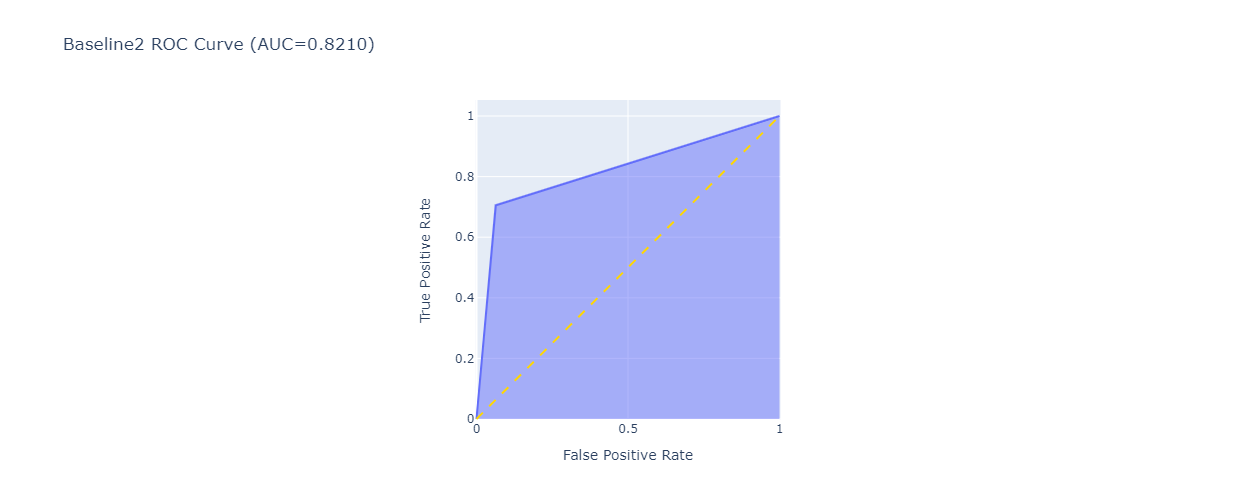

In [143]:
fpr, tpr, thresholds = roc_curve(y_test, b3_test_preds)
fig = px.area(
    x=fpr, y=tpr,
    title=f'Baseline2 ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(color="gold",dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [144]:
print(pd.crosstab(y_test, b3_test_preds, rownames=["Actual"], colnames=["Predicted"]))
print(f"\n{classification_report(y_test, b3_test_preds)}")

Predicted    0    1
Actual             
0          868   59
1           78  187

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       927
           1       0.76      0.71      0.73       265

    accuracy                           0.89      1192
   macro avg       0.84      0.82      0.83      1192
weighted avg       0.88      0.89      0.88      1192



### Baseline 3 Summary
The Pipeline was cross validated 5 times then predicted with original validation set and then predicted test set 1 time, `random_state=42` was inserted to fix results (both splits and model):
* **Raw accuracy**: validation set had a score of 87.75%, test set had 88.51% which is an impressive improvement from the second baseline.
* **Auc**: validation set had a score of 0.811, test set had 0.821 which is higher than the second baseline.
* **F1 score**: validation set had a score of 0.7103, test set had 0.7319 which is higher than the second baseline..

The baseline is saved for comparison as a pandas dataframe

In [145]:
Baseline3 = pd.DataFrame({"val_acc": b3_val_score,"val_auc": b3_val_auc,"val_f1": b3_val_f1,
                          "test_acc": b3_test_score,"test_auc": b3_test_auc,"test_f1": b3_test_f1}, index=["Baseline3"])
Baseline3

,val_acc,val_auc,val_f1,test_acc,test_auc,test_f1
Baseline3,0.877517,0.811885,0.710317,0.885067,0.821007,0.731898


The baseline is added to the baselines dataframe: 

In [146]:
Baselines = pd.concat([Baselines,Baseline3])
Baselines

,val_acc,val_auc,val_f1,test_acc,test_auc,test_f1
Baseline1,0.858221,0.769960,0.651546,0.854866,0.784073,0.667946
Baseline2,0.866611,0.788004,0.677485,0.875839,0.811032,0.713178
Baseline3,0.877517,0.811885,0.710317,0.885067,0.821007,0.731898


Plotting Baselines for comparisons:

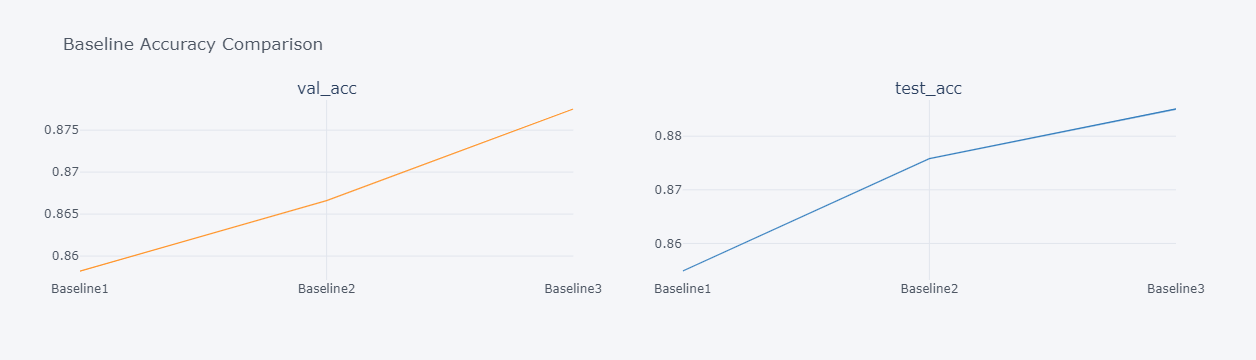

In [147]:
import plotly.graph_objs as go
ordered = ['val_acc','test_acc','val_auc','test_auc','val_f1','test_f1'] 
Baselines[ordered[:2]].iplot(subplots=True, subplot_titles=ordered[:2], legend=False, title = 'Baseline Accuracy Comparison')

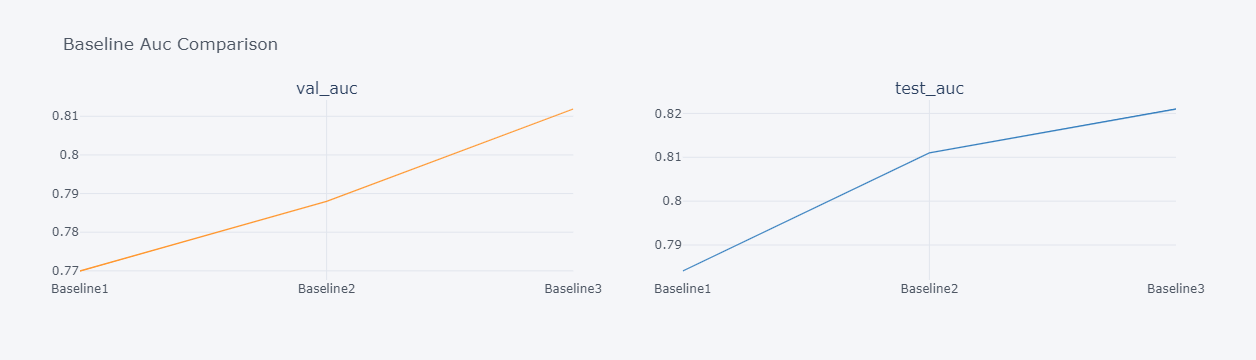

In [148]:
Baselines[ordered[2:4]].iplot(subplots=True, subplot_titles=ordered[2:4], legend=False, title = 'Baseline Auc Comparison')

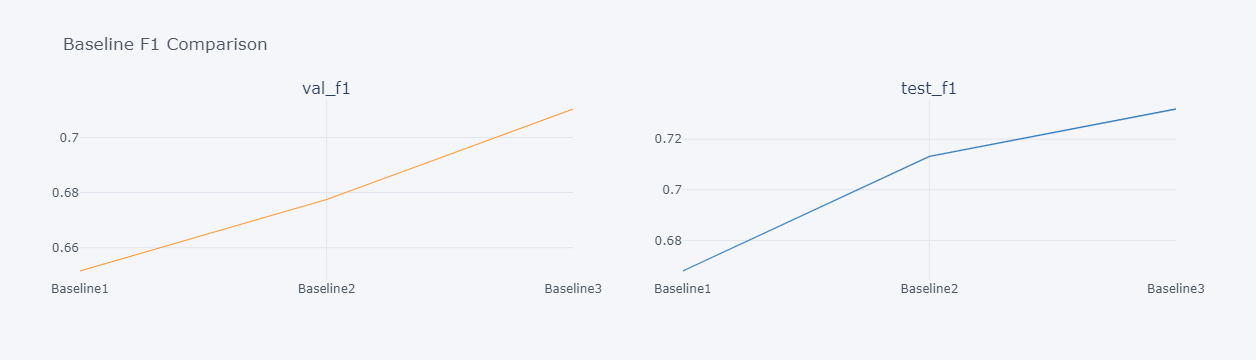

In [149]:
Baselines[ordered[4:]].iplot(subplots=True, subplot_titles=ordered[4:], legend=False, title = 'Baseline F1 Comparison')

## Baseline 4: Random Forest, Gradient Boosting and Voting Classifier. 

### Decisions:
* **Preprocessing:**
    1. **Missing data:** hyperparamer tune.               
    2. **Feature Engineering**: categoric labels - one hot encoding, continuous parameters: standart scaling (z-score).
* **Model training** - using grid search in validation data on a 3 diffrent ensemble models for maximizing "f1".
* **Model testing** - train on whole train + validation set and use test data for results.

In [150]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

clf1 = LogisticRegression(random_state=42)
clf2 = SVC(random_state=42)
clf3 = GaussianNB()
eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('gnb', clf3)], voting='hard')

RF = RandomForestClassifier(random_state=42)

XGB = XGBClassifier(eval_metric='binary:logistic')

Baseline4 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', PipelineHelper([('eclf', eclf),
                                   ('rf', RF),
                                   ('xgb', XGB)
                                                       ]))
                             ])
Baseline4

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MORTDUE', 'VALUE', 'CLAGE',
                                                   'DEBTINC', 'LOAN']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oh',
                                                                   OneHotEncoder())]),
                          

In [151]:
Baseline4.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'model', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__disc', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__scaler', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__imputer', 'preprocessor__cat__oh', 'preprocessor__cat__imputer__add_indicator'

**Grid Search CV**

The validation will be searched with 3 ensembel models: RandomForestClassifier, VotingClassifier(SCV,LR,GNB) and XGBoostClassifier.
`random_state = 42` is inserted for fixing results.

In [152]:
hyperparameters = { 
                   'preprocessor__num__imputer__strategy': ['mean', 'median'],
                    'preprocessor__cat__imputer__strategy': ['constant', 'most_frequent'],
                    'preprocessor__disc__imputer__strategy': ['mean', 'median'],
                    'model__selected_model': Baseline4.named_steps['model'].generate({   
                    'eclf__svc__C': [0.1,0.5,1],
                    'eclf__lr__C': np.logspace(-4, 4, 5),
                    'eclf__lr__solver': ["lbfgs", "liblinear"],
                    'eclf__gnb__var_smoothing': np.logspace(0,-9, num=5),    
                    'rf__criterion': ["gini","entropy"],    
                    'rf__n_estimators': [50,100,200],
                    'rf__max_features':  [1,3,5],
                    'rf__min_samples_leaf':  [2,3,4],
                    'xgb__max_depth': [4,5,6],
                                                
    })}

**fit pipeline** 

In [153]:
b4_test_clf = GridSearchCV(Baseline4, hyperparameters,cv = 5, scoring = "f1", n_jobs = -1, verbose = 2) 

In [154]:
%%time
# Fit and tune model
b4_test_clf.fit(X_train, y_train)

Fitting 5 folds for each of 1656 candidates, totalling 8280 fits
Wall time: 11min 3s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MORTDUE',
                                                                          'VALUE',
                                                                          'CLAGE',
                                                                          'DEBTINC',
                                                                          'LOAN']),
     

**The Chosen Parameters**

In [155]:
b4_test_clf.best_params_

{'model__selected_model': ('rf',
  {'criterion': 'gini',
   'max_features': 5,
   'min_samples_leaf': 2,
   'n_estimators': 200}),
 'preprocessor__cat__imputer__strategy': 'constant',
 'preprocessor__disc__imputer__strategy': 'median',
 'preprocessor__num__imputer__strategy': 'mean'}

**Validation Prediction**

In [156]:
b4_val_clf = b4_test_clf.best_estimator_
b4_val_clf.fit(X_train2, y_train2)
b4_val_preds = b4_val_clf.predict(X_val)

# Evaluate the model
b4_val_score = accuracy_score(y_val, b4_val_preds)
b4_val_auc = roc_auc_score(y_val, b4_val_preds)
b4_val_f1 = f1_score(y_val, b4_val_preds)

print('accuracy score:', b4_val_score)
print("roc auc score: ",b4_val_auc)
print("f1 score: ",b4_val_f1)

accuracy score: 0.9035234899328859
roc auc score:  0.8058906760440292
f1 score:  0.7392290249433107


**Test Prediction**

In [157]:
b4_test_preds = b4_test_clf.predict(X_test)

# Evaluate the model
b4_test_score = accuracy_score(y_test, b4_test_preds)
b4_test_auc = roc_auc_score(y_test, b4_test_preds)
b4_test_f1 = f1_score(y_test, b4_test_preds)

print('accuracy score:', b4_test_score)
print("roc auc score: ",b4_test_auc)
print("f1 score: ",b4_test_f1)

accuracy score: 0.9060402684563759
roc auc score:  0.8196698622051249
f1 score:  0.7586206896551724


**Area Under Curve plot**

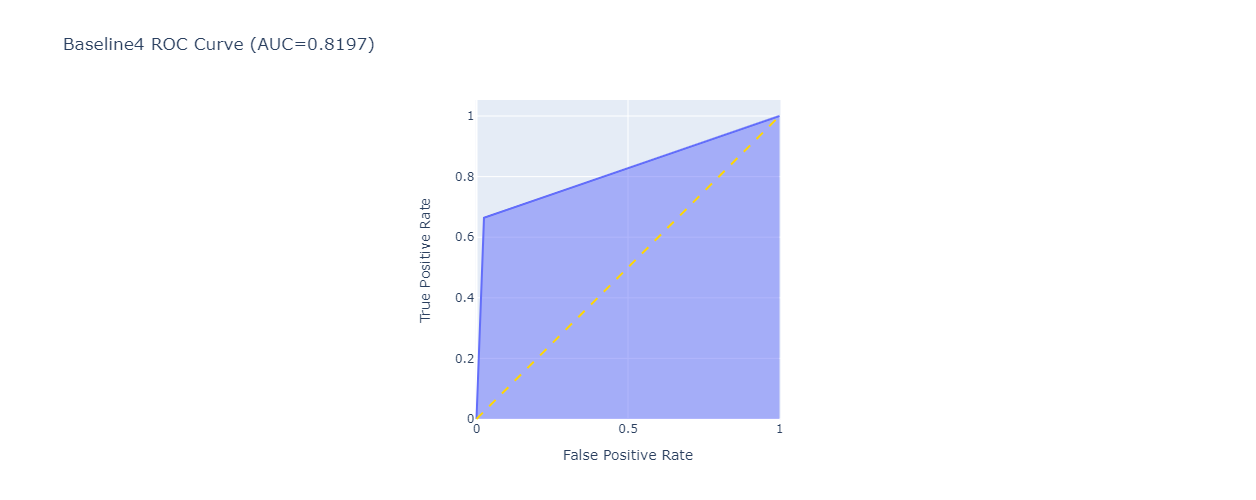

In [168]:
fpr, tpr, thresholds = roc_curve(y_test, b4_test_preds)
fig = px.area(
    x=fpr, y=tpr,
    title=f'Baseline4 ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(color="gold",dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [159]:
print(pd.crosstab(y_test, b4_test_preds, rownames=["Actual"], colnames=["Predicted"]))
print(f"\n{classification_report(y_test, b4_test_preds)}")

Predicted    0    1
Actual             
0          904   23
1           89  176

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       927
           1       0.88      0.66      0.76       265

    accuracy                           0.91      1192
   macro avg       0.90      0.82      0.85      1192
weighted avg       0.90      0.91      0.90      1192



### Baseline 4 Summary
The Pipeline was cross validated 5 times then predicted with original validation set and then predicted test set 1 time, `random_state=42` was inserted to fix results (both splits and model):
* **Raw accuracy**: validation set had a score of 90.35%, test set had 90.6% which is an amazing improvement from the third baseline.
* **Auc**: validation set had a score of 0.8059, test set had 0.8197 which is slightly lower than the second baseline.
* **F1 score**: validation set had a score of 0.7392, test set had 0.7586 which is higher than the second baseline..

The baseline is saved for comparison as a pandas dataframe

In [160]:
Baseline4 = pd.DataFrame({"val_acc": b4_val_score,"val_auc": b4_val_auc,"val_f1": b4_val_f1,
                          "test_acc": b4_test_score,"test_auc": b4_test_auc,"test_f1": b4_test_f1}, index=["Baseline4"])
Baseline4

,val_acc,val_auc,val_f1,test_acc,test_auc,test_f1
Baseline4,0.903523,0.805891,0.739229,0.90604,0.81967,0.758621


The baseline is added to the baselines dataframe: 

In [167]:
Baselines = pd.concat([Baseline1,Baseline2,Baseline3,Baseline4])
Baselines

,val_acc,val_auc,val_f1,test_acc,test_auc,test_f1
Baseline1,0.858221,0.769960,0.651546,0.854866,0.784073,0.667946
Baseline2,0.866611,0.788004,0.677485,0.875839,0.811032,0.713178
Baseline3,0.877517,0.811885,0.710317,0.885067,0.821007,0.731898
Baseline4,0.903523,0.805891,0.739229,0.906040,0.819670,0.758621
